# Load data from Smart-Kages
The data will be loaded from DLC .h5 pose files into `movement` datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from movement.filtering import filter_by_confidence
from movement.io import load_poses
from movement.kinematics import compute_pairwise_distances, compute_speed
from movement.plots import plot_centroid_trajectory, plot_occupancy
from movement.transforms import scale

from smart_kages_movement.io import load_background_frame

## Some global settings

In [19]:
FPS = 2.0  # Frames per second

# Configure seaborn for prettier plots
sns.set_context("notebook")
sns.set_style("ticks")

We define some necessary paths, including the path to the dataframe generated by the 01 notebook.

In [3]:
data_dir = Path.home() / "Data" / "Smart-Kages"
analysis_dir = data_dir / "movement_analysis"
df_path = analysis_dir / "dlc_files.csv"

for path in [data_dir, analysis_dir, df_path]:
    if not path.exists():
        print(f"Path does not exist: {path}")

We load the dataframe containing the paths to all the DLC .h5 files, which is generated in the 01 notebook.

In [4]:
df = pd.read_csv(
    df_path, index_col=[0, 1, 2], dtype={"date": str, "hour": str}
)
df.head()

start_datetime  \
kage  date     hour                        
kage1 20240403 09    2024-04-03 09:54:24   
               10    2024-04-03 10:00:06   
               11    2024-04-03 11:01:07   
               12    2024-04-03 12:01:08   
               13    2024-04-03 13:01:07   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                     video_exists  \
kage  date     hour                 
kage1 20240403 09            True   
               10            True   
               11            True   
               12            True   
               13            True   

                                                       video_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   

                     n_frames  height  width  n_channels  n_timestamps  \
kage  date     hour                                                      
kage1 20240403 09         665     376    500           3           665   
               10        7183     376    500           3          7183   
               11        7064     376    500           1          7064   
               12        7059     376    500           3          7059   
               13        7058     376    500           3          7058   

                                                  timestamps_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/movement_...

## Load all data from a given kage
We will create a function that, given a kage name, will load all the data from the DLC .h5 files and merge them into a single `movement` dataset.

In [ ]:
def kage_to_movement_ds(df: pd.DataFrame, kage: str) -> xr.Dataset:
    """Load all poses for a given kage and return an xarray Dataset.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the paths to pose files and timestamps
        for each 1-hour segment.
    kage : str
        The name of the kage to process, e.g., "kage1", "kage2", etc.

    Returns
    -------
    xr.Dataset
        An xarray Dataset containing the poses for the specified kage,
        with time coordinates assigned based on the corrected timestamps.

    Notes
    -----
    The returned Dataset will have two time coordinates:
    - ``time``: the primary time coordinate based on the corrected timestamps.
    - ``seconds_since_start``: the secondary time coordinate representing
       seconds elapsed since the start of the kage.
    """

    print(f"Processing kage: {kage}")

    def _is_monotonic_increasing(arr):
        """Check if a 1D array is monotonically increasing."""
        return (arr[1:] >= arr[:-1]).all()

    DATETIME_TYPE = "datetime64[ns]"

    df_kage = df.loc[kage]
    n_days = df_kage.index.get_level_values("date").nunique()
    print(f"Number of days: {n_days}")
    n_segments = df_kage.shape[0]
    print(f"Number of 1-hour segment: {n_segments}")
    # Sort by the index to ensure chronological order
    df_kage = df_kage.sort_index()

    kage_start_datetime = pd.Timestamp(df_kage["start_datetime"].iloc[0])

    ds_segments = []  # List of xarray Datasets for each 1-hour segment
    previous_segment_end_datetime = kage_start_datetime

    for date, hour in df_kage.index:
        # Load the pose data for the current 1-hour segment
        poses = load_poses.from_file(
            df_kage.loc[(date, hour), "pose_file_path"],
            source_software="DeepLabCut",
            fps=FPS,
        )
        # Let's get rid of the "individuals" dimension (it's always 1)
        if "individuals" in poses.dims:
            poses = poses.drop_vars("individuals").squeeze("individuals")

        # Load the corrected timestamps for the current 1-hour segment
        timestamps = (
            pd.read_csv(
                df_kage.loc[(date, hour), "timestamps_file_path"],
                header=None,
            )
            .astype(DATETIME_TYPE)
            .to_numpy()
            .flatten()
        )

        # Check if timestamps are monotonically increasing
        assert _is_monotonic_increasing(timestamps), (
            f"Timestamps are not monotonic on {date} at {hour}!"
        )

        # assign time coordinates to the actual datetime timestamps
        poses = poses.assign_coords(time=timestamps)
        poses.attrs["time_unit"] = DATETIME_TYPE

        # Deal with segment overlaps, if any
        segment_start_datetime = pd.Timestamp(
            df_kage.loc[(date, hour), "start_datetime"]
        )
        if segment_start_datetime <= previous_segment_end_datetime:
            print(
                "Warning: segment starts before the previous segment ends: "
                f"{segment_start_datetime} < {previous_segment_end_datetime}. "
                "The overlapping part of the current segment will be dropped."
            )
            # Discard the part of this segment that overlaps the previous one
            poses = poses.sel(time=slice(previous_segment_end_datetime, None))

        # add to list of loaded segments
        ds_segments.append(poses)
        # Update the end datetime of the previous segment
        previous_segment_end_datetime = timestamps[-1]

    # Combine all segments into a single xarray Dataset
    ds_kage = xr.concat(ds_segments, dim="time")
    ds_kage.attrs["kage"] = kage
    ds_kage.attrs["kage_start_datetime"] = kage_start_datetime.isoformat()

    # Ensure the concatenated timestamps are monotonic increasing
    assert _is_monotonic_increasing(ds_kage.time.values), (
        f"Combined timestamps for {kage} are not monotonic increasing!"
    )

    # Assign secondary time coordinate as seconds elapsed since kage start
    seconds_since_kage_start = (
        ds_kage.time.data - np.datetime64(kage_start_datetime)
    ).astype("timedelta64[ms]").astype(float) * 0.001
    ds_kage = ds_kage.assign_coords(
        seconds_since_start=("time", seconds_since_kage_start)
    )

    # load image to use as background frame
    background_img = load_background_frame(
        video_path=df_kage.iloc[0]["video_file_path"], i=0, n_average=100
    )
    ds_kage.attrs["background_image"] = background_img  # Store as an attribute

    return ds_kage  # return the combined dataset for the kage

In [26]:
ds_kage = kage_to_movement_ds(df, "kage3")

Processing kage: kage3
Number of days: 39
Number of 1-hour segment: 855


In [27]:
ds_kage

<xarray.Dataset> Size: 1GB
Dimensions:              (time: 6073880, space: 2, keypoints: 8)
Coordinates:
  * space                (space) <U1 8B 'x' 'y'
  * keypoints            (keypoints) <U10 320B 'snout' 'leftear' ... 'tailbase'
  * time                 (time) datetime64[ns] 49MB 2024-04-02T17:03:26 ... 2...
    seconds_since_start  (time) float64 49MB 0.0 0.501 ... 3.254e+06 3.254e+06
Data variables:
    position             (time, space, keypoints) float64 777MB 464.5 ... 2.151
    confidence           (time, keypoints) float64 389MB 0.9944 1.0 ... 0.06425
Attributes:
    source_software:      DeepLabCut
    ds_type:              poses
    fps:                  2.0
    time_unit:            datetime64[ns]
    source_file:          /Users/nsirmpilatze/Data/Smart-Kages/kage3/analysis...
    kage:                 kage3
    kage_start_datetime:  2024-04-02T17:03:26
    background_image:     [[[ 56  57  56]\n  [ 51  52  51]\n  [ 65  66  65]\n...

Text(0.5, 0.98, 'Confidence Histograms for kage3')

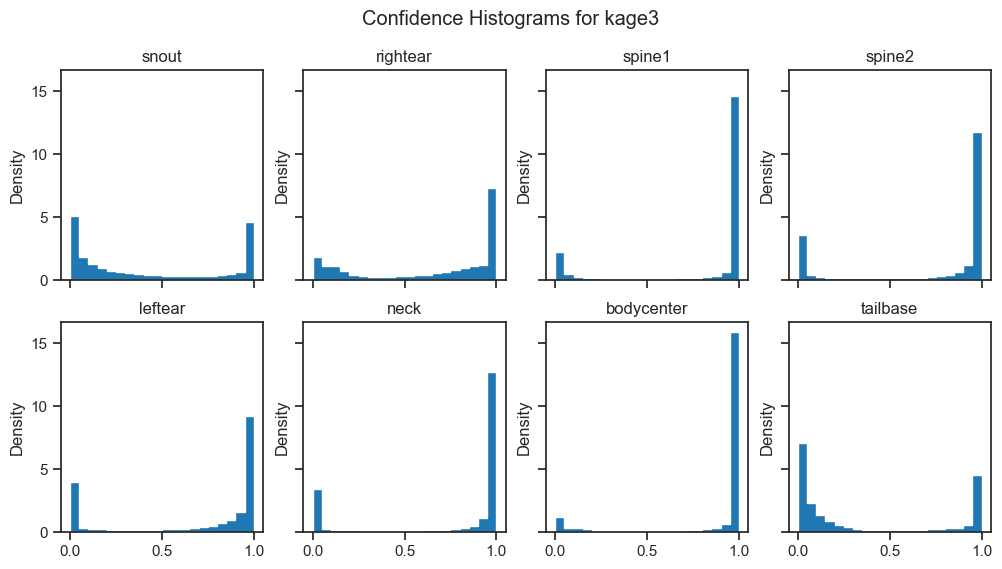

In [28]:
# Let's plot confidence histograms for each keypoint
n_keypoints = ds_kage.sizes["keypoints"]
fig, axes = plt.subplots(
    nrows=2,
    ncols=(n_keypoints + 1) // 2,
    figsize=(12, 6),
    sharey=True,
    sharex=True,
)

for i, kpt in enumerate(ds_kage.keypoints.values):
    ax = axes[i % 2, i // 2]
    ds_kage.confidence.sel(keypoints=kpt).plot.hist(
        bins=20,
        ax=ax,
        label=kpt,
        histtype="stepfilled",
        density=True,
    )
    ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.set_title(kpt)
plt.suptitle(f"Confidence Histograms for {ds_kage.kage}")

In [29]:
use_keypoints = ["spine1", "bodycenter", "spine2", "tailbase"]

ds_kage["position_filtered"] = filter_by_confidence(
    ds_kage.position, ds_kage.confidence, threshold=0.9
)

In [30]:
median_body_length = (
    compute_pairwise_distances(
        ds_kage.position_filtered, dim="keypoints", pairs={"snout": "tailbase"}
    )
    .median()
    .values
)
print(f"Median body length: {median_body_length:.2f} pixels")

Median body length: 61.32 pixels


In [31]:
# dataset indexed by seconds since start
ds_kage_sec = ds_kage.set_index(time="seconds_since_start")

ds_kage_sec["speed_body_lengths"] = compute_speed(
    scale(
        ds_kage_sec.position_filtered,
        factor=1 / median_body_length,
        space_unit="body_length",
    )
)

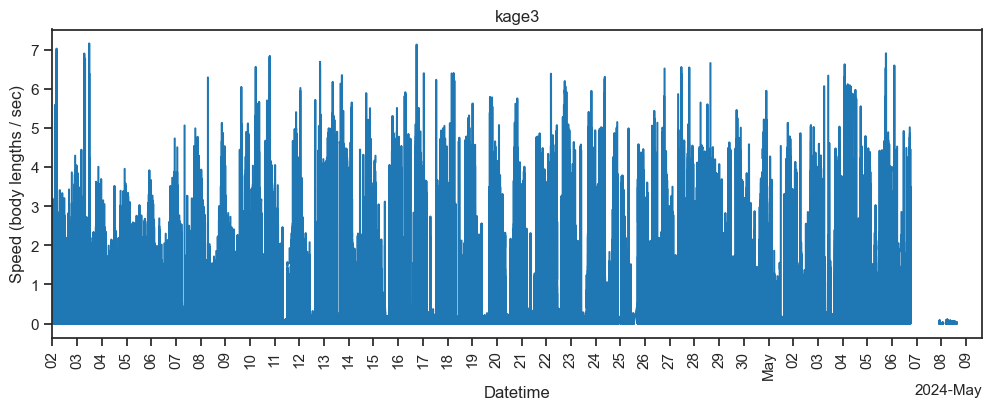

In [32]:
# switch back to datetime for plotting
ds_kage_dt = ds_kage_sec.assign_coords(
    time=ds_kage.time.astype("datetime64[ns]")
)

fig, ax = plt.subplots(figsize=(12, 4))
ds_kage_dt["speed_body_lengths"].sel(keypoints="bodycenter").plot.line(
    x="time", ax=ax
)
ax.set_title(ds_kage.attrs["kage"])
ax.set_ylabel("Speed (body lengths / sec)")
ax.set_xlabel("Datetime")
ax.set_xlim(
    ds_kage_dt.time.min().values,
    ds_kage_dt.time.max().values,
)
# set x-ticks to every day
plt.xticks(
    pd.date_range(
        start=ds_kage_dt.time.min().values,
        end=ds_kage_dt.time.max().values,
        freq="1D",
    ),
    rotation=90,
);

2025-05-28 09:35:40.633 | WARNING  | matplotlib._api:warn_external:391 - /var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_66074/2663713360.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(



(0.0, 500.0)

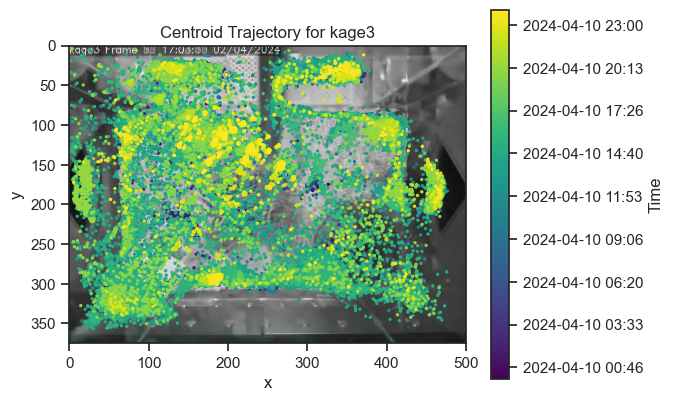

In [35]:
time_window = slice("2024-04-10T00:00:00", "2024-04-11T00:00:00")
background_img = ds_kage.attrs["background_image"]

fig, ax = plt.subplots()
height, width = background_img.shape[:2]
ax.imshow(background_img)
plot_centroid_trajectory(
    ds_kage_dt.sel(time=time_window).position, ax=ax, s=2, cmap="viridis"
)
# Get the colorbar ticks from the ax and format them as timestamps
cbar = ax.collections[0].colorbar
current_ticks = cbar.get_ticks()
cbar.set_ticklabels(
    [pd.Timestamp(t).strftime("%Y-%m-%d %H:%M") for t in current_ticks]
)
ax.set_title(f"Centroid Trajectory for {ds_kage.kage}")
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])

Text(0.5, 1.0, 'Body occupancy for {ds_kage.kage} (log scale)')

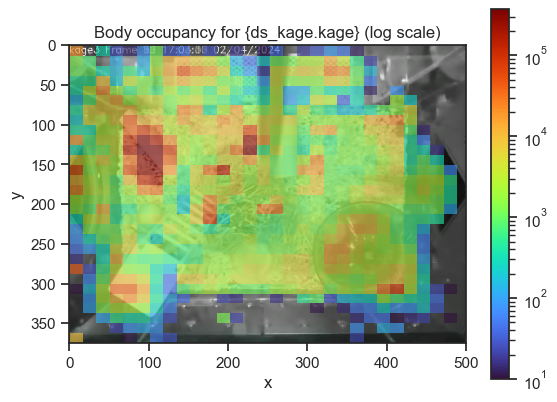

In [36]:
fig, ax = plt.subplots()
ax.imshow(background_img)
plot_occupancy(
    ds_kage.position,
    # conside the centroid of the following keypoints
    keypoints=use_keypoints,
    ax=ax,
    cmap="turbo",
    norm="log",  # log scale the colormap
    cmin=10,  # only show occupancy above 1 frame
    alpha=0.6,  # some transparency
)
# invert y-axis to match the video frame
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])
ax.set_title("Body occupancy for {ds_kage.kage} (log scale)")